# Importing packages and the CNN we built

In [36]:
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Import our net
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=4000, bias=True)
  (fc1_bn): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=4000, out_features=1000, bias=True)
  (fc2_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=T

## Transform the dataset 

Transforme the dataset of images and keypoints.

To define the data transform (http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`.

In [38]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the datasetfrom Notebook 1 
from data_load import FacialKeypointsDataset
# the transforms from Notebook 1 
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## Define the data_transform
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing 
assert(data_transform is not None), 'Define a data_transform'

In [39]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# Print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data


In [40]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

How this model performs before it trains. 

#### Load in the test dataset

In [41]:
# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [42]:
# load test data in batches
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

Steps to test the model on a test sample of data:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor
3. Forward pass the image through the net to get the predicted keypoints.


In [43]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging 

In [44]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


## Visualize the predicted keypoints


In [45]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image im grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

`visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

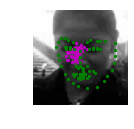

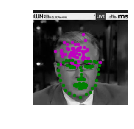

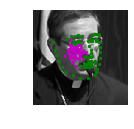

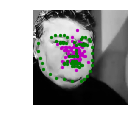

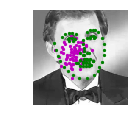

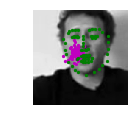

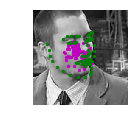

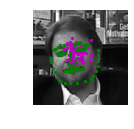

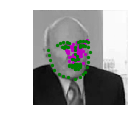

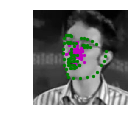

In [46]:
# visualize the output
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

# Training


In [47]:
# Choose a loss function and an optimizer for our regression problem
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


### Training and Initial Observation

In [48]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/3200))
                running_loss = 0.0

    print('Finished Training')


In [49]:
# train the network
n_epochs = 10
train_net(n_epochs)


Epoch: 1, Batch: 10, Avg. Loss: 0.000987795628607273
Epoch: 1, Batch: 20, Avg. Loss: 0.0006676305504515767
Epoch: 1, Batch: 30, Avg. Loss: 0.0005050409259274601
Epoch: 1, Batch: 40, Avg. Loss: 0.00040667707100510597
Epoch: 1, Batch: 50, Avg. Loss: 0.00036741543794050814
Epoch: 1, Batch: 60, Avg. Loss: 0.00040765445213764907
Epoch: 1, Batch: 70, Avg. Loss: 0.0003706225310452282
Epoch: 1, Batch: 80, Avg. Loss: 0.000555432834662497
Epoch: 1, Batch: 90, Avg. Loss: 0.00028950810432434084
Epoch: 1, Batch: 100, Avg. Loss: 0.0003156952385324985
Epoch: 2, Batch: 10, Avg. Loss: 0.0002523403754457831
Epoch: 2, Batch: 20, Avg. Loss: 0.00025405355961993336
Epoch: 2, Batch: 30, Avg. Loss: 0.00025493969209492204
Epoch: 2, Batch: 40, Avg. Loss: 0.0002480072621256113
Epoch: 2, Batch: 50, Avg. Loss: 0.00024919175426475705
Epoch: 2, Batch: 60, Avg. Loss: 0.0002794783329591155
Epoch: 2, Batch: 70, Avg. Loss: 0.0001854811212979257
Epoch: 2, Batch: 80, Avg. Loss: 0.00018360749585554002
Epoch: 2, Batch: 90, 

## Test data

See how the model performs on previously unseen, test data. 

In [52]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


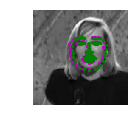

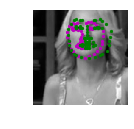

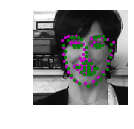

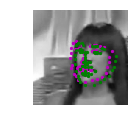

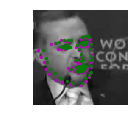

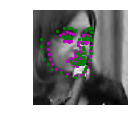

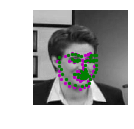

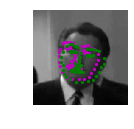

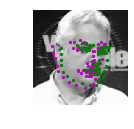

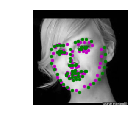

In [53]:
# Visualize your test output
visualize_output(test_images, test_outputs, gt_pts)

In [95]:
# Saving the model
model_dir = 'saved_models/'
model_name = 'keypoints_model.pt'

torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.1195448  -0.01017091  0.3078885 ]
 [-0.28113395 -0.16858152  0.2523119 ]
 [-0.09708244 -0.09511566  0.2225108 ]]
(3, 3)


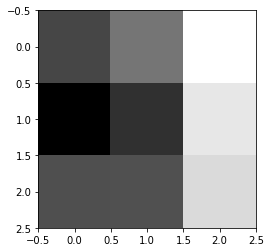

In [93]:
# Get the weights in the first conv layer, "conv1"
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 15

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Filter an image to see the effect of a convolutional kernel

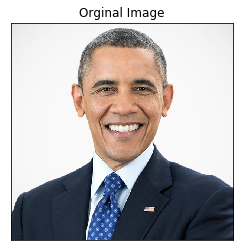

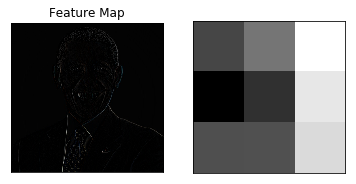

In [94]:

import cv2

# Loading the image
image = cv2.imread('C:/Users/jeanjules.bigeard/OneDrive - Neato Robotics/Documents/obama.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

# Applying the image
filtered = cv2.filter2D(image, -1, w[filter_index][0])

# Visualization
fig = plt.figure()
ax = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()